In [81]:
# import numpy as np
# import pandas as pd
# from sklearn.metrics.pairwise import euclidean_distances
# from sklearn.metrics.pairwise import linear_kernel
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.feature_extraction.text import TfidfVectorizer
# from collections import Counter
# import mysql.connector
# import warnings
# warnings.filterwarnings("ignore")



# # join and concatenate inputted columns
# def create_soup(x, features):
#     soup_parts = [str(x[feature]) for feature in features if x[feature] is not None]  # Convert to string and filter out None values
#     return ' '.join(soup_parts)

# # count number of likeable elements for film
# def count_likeable(row):
#     features = ['primaryTitle', 'plot', 'averageRating', 'genres', 'runtimeMinutes', 'startYear', 'director', 'cinematographer', 'writer', 'producer', 'editor', 'composer']
#     atts = sum(1 for col in row[features] if col is not None)
#     cast = len(row['cast'].split(','))
#     return atts+cast

# # get user loved films from db
# def get_loved_films(user_id):

#     mydb = mysql.connector.connect(
#         host="localhost",
#         user="root",
#         password="Leicester69lol",
#         database="users"
#     )

#     mycursor = mydb.cursor()

#     sql_query = "SELECT tconst FROM user_loved_films WHERE user_id = %s"

#     mycursor.execute(sql_query, (user_id,))

#     rows = mycursor.fetchall()

#     tconst_list = [tconst[0] for tconst in rows]

#     mycursor.close()
#     mydb.close()

#     loved_films_df = data[data['tconst'].isin(tconst_list)]

#     return loved_films_df

# # get user liked attributes from db
# def get_liked_attributes(user_id):

#     mydb = mysql.connector.connect(
#         host="localhost",
#         user="root",
#         password="Leicester69lol",
#         database="users"
#     )

#     mycursor = mydb.cursor()

#     sql_query = "SELECT * FROM user_liked_attributes WHERE user_id = %s"

#     mycursor.execute(sql_query, (user_id,))

#     attribute_fetch = mycursor.fetchall()

#     tconst_list = [row[1] for row in attribute_fetch]
#     attribute_bin = [row[1:] for row in attribute_fetch]

#     mycursor.close()
#     mydb.close()

#     attributes_template = ['tconst','primaryTitle', 'plot', 'averageRating', 'genres', 'runtimeMinutes', 'startYear', 'director', 'cinematographer', 'writer', 'producer', 'editor', 'composer']
#     liked_attributes_df = pd.DataFrame(columns=attributes_template)

#     x = 0
#     for tconst, att_bin in zip(tconst_list, attribute_bin):
#         row_values = [tconst]  # Initialize row values with tconst
#         for liked, attribute in zip(att_bin[1:], attributes_template[1:]):
#             film_att = data[data['tconst'] == tconst]

#             if liked == 1:
#                 row_values.append(film_att[attribute].values[0])
#             else:
#                 row_values.append(None) 
#         liked_attributes_df.loc[x] = row_values
#         x+=1

#     return liked_attributes_df

# # get user liked cast from db
# def get_liked_cast(user_id):
#     mydb = mysql.connector.connect(
#         host="localhost",
#         user="root",
#         password="Leicester69lol",
#         database="users"
#     )

#     mycursor = mydb.cursor()

#     sql_query = "SELECT * FROM user_liked_cast WHERE user_id = %s"

#     mycursor.execute(sql_query, (user_id,))

#     cast_fetch = mycursor.fetchall()

#     mycursor.close()
#     mydb.close()

#     cast = [row[1:] for row in cast_fetch]
#     liked_cast_df = pd.DataFrame(cast, columns=['tconst', 'name'])

#     return liked_cast_df

# # get user watchlist from db
# def get_watchlist(user_id):
#     mydb = mysql.connector.connect(
#         host="localhost",
#         user="root",
#         password="Leicester69lol",
#         database="users"
#     )

#     mycursor = mydb.cursor()

#     sql_query = "SELECT * FROM user_watchlist WHERE user_id = %s"

#     mycursor.execute(sql_query, (user_id,))


#     watchlist_fetch = mycursor.fetchall()

#     mycursor.close()
#     mydb.close()

#     tconst_list = [row[1] for row in watchlist_fetch]
#     attributes_template = ['tconst','primaryTitle', 'plot', 'averageRating', 'genres', 'runtimeMinutes', 'startYear', 'cast', 'director', 'cinematographer', 'writer', 'producer', 'editor', 'composer']
#     watchlist_df = pd.DataFrame(columns=attributes_template)

#     x = 0
#     for tconst in tconst_list:
#         watchlist_df.loc[x] = data[data['tconst'] == tconst][attributes_template].values[0]
#         x+=1

#     return watchlist_df

# # calculate % of liked attributes of film in profile
# def calculate_percentage(row):
#     total_attributes = row['total_likeable']
#     total_liked = row['num_liked_atts']
#     percentage = total_liked / total_attributes
#     return percentage 

# # count liked attributes for film
# def count_liked(row):
#     features = ['primaryTitle', 'plot', 'averageRating', 'genres', 'runtimeMinutes', 'startYear', 'director', 'cinematographer', 'writer', 'producer', 'editor', 'composer']
#     atts = sum(1 for col in row[features] if pd.notna(col))  # Change this line
#     cast = 0
#     if not pd.isna(row['cast']):
#         cast = len(row['cast'].split(','))
    
#     return atts + cast

# # CREATE USER PROFILE
# def get_user_profile(user_id):
#     # get user film preferences from db
#     lovedFilms = get_loved_films(user_id)
#     likedAtt = get_liked_attributes(user_id)
#     likedCast = get_liked_cast(user_id)
#     watchlist = get_watchlist(user_id)

#     # merge liked cast with liked attribute table
#     likedCast_grouped = likedCast.groupby('tconst')['name'].apply(lambda x: ', '.join(x.dropna())).reset_index()
#     likedAttributes = pd.merge(likedAtt, likedCast_grouped, on='tconst', how='outer') #outer join instead of left?
#     likedAttributes.rename(columns={'name': 'cast'}, inplace=True)

#     # format user_profile dataframe
#     merged_love_liked = pd.concat([lovedFilms, likedAttributes], ignore_index=True)
#     user_profile = pd.merge(merged_love_liked, data[['tconst', 'total_likeable']], on='tconst', how='left')
#     user_profile = user_profile.drop(columns=['poster', 'total_likeable_x'])
#     user_profile.rename(columns={'total_likeable_y': 'total_likeable'}, inplace=True)

#     # initialise columns to calculate likeage
#     user_profile['num_liked_atts'] = 0
#     user_profile['likeage'] = 0.0
#     # count total liked attributes for each film in profile
#     for index, film in user_profile.iterrows():
#         tconst = film['tconst']
#         user_profile.loc[user_profile['tconst'] == tconst, 'num_liked_atts'] = count_liked(film)

#     # calculate likeage for each film in profile
#     user_profile['likeage'] = user_profile.apply(lambda row: calculate_percentage(row), axis=1)
#     user_profile.drop(columns=['num_liked_atts', 'total_likeable'], inplace=True)

#     return (user_profile, lovedFilms)

# # split user profile into likes by group
# def collate_liked_groups(user_profile):
#     group_dataframes = []

#     # Define dictionary to map group names to corresponding columns
#     group_columns = {
#         'liked_title_plot': ['primaryTitle', 'plot', 'likeage'],
#         'liked_cast': ['cast', 'likeage'],
#         'liked_crew': ['director', 'cinematographer', 'writer', 'producer', 'editor', 'composer', 'likeage'],
#         'liked_genre': ['genres', 'likeage'],
#         'liked_meta': ['averageRating', 'startYear', 'runtimeMinutes', 'likeage']
#     }

#     # Iterate over the dictionary and create group dataframes
#     for group_name, columns in group_columns.items():
#         group_df = user_profile[columns].copy()
#         # Drop rows with all NaN values in specified columns
#         group_df = group_df.dropna(subset=columns[:-1], how='all')
#         group_dataframes.append(group_df)

#     return group_dataframes

# # cosine similarity vector with tf-idf between films in row and column
# def create_similarity_vector(row, column):
#     tfidf = TfidfVectorizer(stop_words='english')
#     row_soup_temp = row.apply(lambda x: create_soup(x, row.columns), axis=1)
#     row_soup = row_soup_temp.fillna('')
#     row_matrix = tfidf.fit_transform(row_soup)

#     column_soup_temp = column.apply(lambda x: create_soup(x, column.columns), axis=1)
#     column_soup = column_soup_temp.fillna('')
#     column_matrix = tfidf.transform(column_soup)

#     return linear_kernel(row_matrix, column_matrix)

# # euclidean distance vector for numerical attributes of film
# def create_euclidean_vector(row, column):
#     scaler = MinMaxScaler()
#     row = row.fillna('')
#     column = column.fillna(0)

#     row_normalized = scaler.fit_transform(row)
#     column_normalized = scaler.transform(column)
#     distances = euclidean_distances(row_normalized, column_normalized)
#     euclidean_matrix = 1 / (1 + distances)
#     return euclidean_matrix

# # get top N films similar to user profile based on input vector (NOT CURRENTLY IN USE)
# def get_similar_films(vector, N):
#     filtered_vector = vector[~data['tconst'].isin(lovedFilms['tconst'])] #don't recommend film the user has already loved
#     mean_similarity = np.mean(filtered_vector, axis=1)
#     sorted_indices = np.argsort(mean_similarity)[::-1]
#     top_N = sorted_indices[:N]
#     return data.iloc[top_N]

# # function to calculate unified recommendations
# def get_unified_recommendations(user_profile_groups, similarity_vectors, N):

#     weighted_scores = {}
    
#     # scale similarity score in respective vector based on likeage of feature
#     for group, attributes in user_profile_groups.items():
#         similarity_vector = similarity_vectors[group][~data['tconst'].isin(user_profile['tconst'])] #don't recommend films already in profile
#         likeage_array = np.array(list(attributes['likeage'].tolist()))
#         weighted_similarity = similarity_vector * likeage_array

#         # meta columns have higher similarity since its numerical so adjust for this
#         if group == 'meta':
#             scaling_factor = 1 - weighted_similarity
#             weighted_similarity *= scaling_factor

#         # dictionary of groups and weighted similarity vectors 
#         weighted_scores[group] = weighted_similarity

#      # combine weighted similarity scores across all groups
#     combined_scores = np.sum(list(weighted_scores.values()), axis=0)

#     # calculate mean similarity scores
#     mean_similarity = np.mean(combined_scores, axis=1)

#     # sort the mean similarity scores and retrieve the top N indices
#     sorted_indices = np.argsort(mean_similarity)[::-1][:N]

#     return data.iloc[sorted_indices]


# data = pd.read_json('webpage/films.json')
# data['total_likeable'] = data.apply(lambda x: count_likeable(x), axis=1)
# data.head()


# # get update user profile and loved films
# get_profile = get_user_profile('57')
# user_profile = get_profile[0]
# lovedFilms = get_profile[1]

# # get groups of liked attributes
# grouped_likes = collate_liked_groups(user_profile)
# liked_plot = grouped_likes[0]
# liked_cast = grouped_likes[1]
# liked_crew = grouped_likes[2]
# liked_genre = grouped_likes[3]
# liked_meta = grouped_likes[4]

# # Define the list of features excluding 'likeage'
# plot_features = [col for col in liked_plot.columns if col != 'likeage']
# crew_features = [col for col in liked_crew.columns if col != 'likeage']
# cast_features = [col for col in liked_cast.columns if col != 'likeage']
# genre_features = [col for col in liked_genre.columns if col != 'likeage']
# meta_features = [col for col in liked_meta.columns if col != 'likeage']

# # Call the function with the selected columns
# plot_matrix = create_similarity_vector(data[plot_features], liked_plot[plot_features])
# crew_matrix = create_similarity_vector(data[crew_features], liked_crew[crew_features])
# cast_matrix = create_similarity_vector(data[cast_features], liked_cast[cast_features])
# genre_matrix = create_similarity_vector(data[genre_features], liked_genre[genre_features])
# meta_matrix = create_euclidean_vector(data[meta_features], liked_meta[meta_features])


# # Similarity vectors for each group
# similarity_vectors = {
#     'plot': plot_matrix,
#     'cast': cast_matrix,
#     'crew': crew_matrix,
#     'genre': genre_matrix,
#     'meta': meta_matrix
# }

# user_profile_groups = {
#     'plot': liked_plot,
#     'cast': liked_cast,
#     'crew': liked_crew,
#     'genre': liked_genre,
#     'meta': liked_meta
# }


# get_unified_recommendations(user_profile_groups, similarity_vectors, 20)



In [82]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import mysql.connector
import warnings
warnings.filterwarnings("ignore")

data = pd.read_json('webpage/films.json')

# join and concatenate inputted columns
def create_soup(x, features):
    soup_parts = [str(x[feature]) for feature in features if x[feature] is not None]  # Convert to string and filter out None values
    return ' '.join(soup_parts)

# count number of likeable elements for film
def count_likeable(row):
    features = ['primaryTitle', 'plot', 'averageRating', 'genres', 'runtimeMinutes', 'startYear', 'director', 'cinematographer', 'writer', 'producer', 'editor', 'composer']
    atts = sum(1 for col in row[features] if col is not None)
    cast = len(row['cast'].split(','))
    return atts+cast

# get user loved films from db
def get_loved_films(user_id):

    mydb = mysql.connector.connect(
        host="localhost",
        user="root",
        password="Leicester69lol",
        database="users"
    )

    mycursor = mydb.cursor()

    sql_query = "SELECT tconst FROM user_loved_films WHERE user_id = %s"

    mycursor.execute(sql_query, (user_id,))

    rows = mycursor.fetchall()

    tconst_list = [tconst[0] for tconst in rows]

    mycursor.close()
    mydb.close()

    loved_films_df = data[data['tconst'].isin(tconst_list)]

    return loved_films_df

# get user liked attributes from db
def get_liked_attributes(user_id):

    mydb = mysql.connector.connect(
        host="localhost",
        user="root",
        password="Leicester69lol",
        database="users"
    )

    mycursor = mydb.cursor()

    sql_query = "SELECT * FROM user_liked_attributes WHERE user_id = %s"

    mycursor.execute(sql_query, (user_id,))

    attribute_fetch = mycursor.fetchall()

    tconst_list = [row[1] for row in attribute_fetch]
    attribute_bin = [row[1:] for row in attribute_fetch]

    mycursor.close()
    mydb.close()

    attributes_template = ['tconst','primaryTitle', 'plot', 'averageRating', 'genres', 'runtimeMinutes', 'startYear', 'director', 'cinematographer', 'writer', 'producer', 'editor', 'composer']
    liked_attributes_df = pd.DataFrame(columns=attributes_template)

    x = 0
    for tconst, att_bin in zip(tconst_list, attribute_bin):
        row_values = [tconst]  # Initialize row values with tconst
        for liked, attribute in zip(att_bin[1:], attributes_template[1:]):
            film_att = data[data['tconst'] == tconst]

            if liked == 1:
                row_values.append(film_att[attribute].values[0])
            else:
                row_values.append(None) 
        liked_attributes_df.loc[x] = row_values
        x+=1

    return liked_attributes_df

# get user liked cast from db
def get_liked_cast(user_id):
    mydb = mysql.connector.connect(
        host="localhost",
        user="root",
        password="Leicester69lol",
        database="users"
    )

    mycursor = mydb.cursor()

    sql_query = "SELECT * FROM user_liked_cast WHERE user_id = %s"

    mycursor.execute(sql_query, (user_id,))

    cast_fetch = mycursor.fetchall()

    mycursor.close()
    mydb.close()

    cast = [row[1:] for row in cast_fetch]
    liked_cast_df = pd.DataFrame(cast, columns=['tconst', 'name'])

    return liked_cast_df

# get user watchlist from db
def get_watchlist(user_id):
    mydb = mysql.connector.connect(
        host="localhost",
        user="root",
        password="Leicester69lol",
        database="users"
    )

    mycursor = mydb.cursor()

    sql_query = "SELECT * FROM user_watchlist WHERE user_id = %s"

    mycursor.execute(sql_query, (user_id,))


    watchlist_fetch = mycursor.fetchall()

    mycursor.close()
    mydb.close()

    tconst_list = [row[1] for row in watchlist_fetch]
    attributes_template = ['tconst','primaryTitle', 'plot', 'averageRating', 'genres', 'runtimeMinutes', 'startYear', 'cast', 'director', 'cinematographer', 'writer', 'producer', 'editor', 'composer']
    watchlist_df = pd.DataFrame(columns=attributes_template)

    x = 0
    for tconst in tconst_list:
        watchlist_df.loc[x] = data[data['tconst'] == tconst][attributes_template].values[0]
        x+=1

    return watchlist_df

# calculate % of liked attributes of film in profile
def calculate_percentage(row):
    total_attributes = row['total_likeable']
    total_liked = row['num_liked_atts']
    percentage = total_liked / total_attributes
    return percentage 

# count liked attributes for film
def count_liked(row):
    features = ['primaryTitle', 'plot', 'averageRating', 'genres', 'runtimeMinutes', 'startYear', 'director', 'cinematographer', 'writer', 'producer', 'editor', 'composer']
    atts = sum(1 for col in row[features] if pd.notna(col))  # Change this line
    cast = 0
    if not pd.isna(row['cast']):
        cast = len(row['cast'].split(','))
    
    return atts + cast

# CREATE USER PROFILE
def get_user_profile(user_id):
    # get user film preferences from db
    lovedFilms = get_loved_films(user_id)
    likedAtt = get_liked_attributes(user_id)
    likedCast = get_liked_cast(user_id)
    watchlist = get_watchlist(user_id)

    # merge liked cast with liked attribute table
    likedCast_grouped = likedCast.groupby('tconst')['name'].apply(lambda x: ', '.join(x.dropna())).reset_index()
    likedAttributes = pd.merge(likedAtt, likedCast_grouped, on='tconst', how='outer') #outer join instead of left?
    likedAttributes.rename(columns={'name': 'cast'}, inplace=True)

    # format user_profile dataframe
    merged_love_liked = pd.concat([lovedFilms, likedAttributes], ignore_index=True)
    user_profile = pd.merge(merged_love_liked, data[['tconst', 'total_likeable']], on='tconst', how='left')
    user_profile = user_profile.drop(columns=['poster', 'total_likeable_x'])
    user_profile.rename(columns={'total_likeable_y': 'total_likeable'}, inplace=True)

    # initialise columns to calculate likeage
    user_profile['num_liked_atts'] = 0
    user_profile['likeage'] = 0.0
    # count total liked attributes for each film in profile
    for index, film in user_profile.iterrows():
        tconst = film['tconst']
        user_profile.loc[user_profile['tconst'] == tconst, 'num_liked_atts'] = count_liked(film)

    # calculate likeage for each film in profile
    user_profile['likeage'] = user_profile.apply(lambda row: calculate_percentage(row), axis=1)
    user_profile.drop(columns=['num_liked_atts', 'total_likeable'], inplace=True)

    return (user_profile, lovedFilms)

# get array of names from inputted dataframe
def extract_names(data):
    names = set()
    for column in data.columns:
        for value in data[column]:
            if value and isinstance(value, str) and value.lower() not in ['none', 'null', 'nan']:
                names.update(value.split(", "))
    return list(names)

# split user profile into likes by group
def collate_liked_groups(user_profile):
    group_dataframes = []

    # Define dictionary to map group names to corresponding columns
    group_columns = {
        'liked_title_plot': ['primaryTitle', 'plot', 'likeage'],
        'liked_cast': ['cast', 'likeage'],
        'liked_crew': ['director', 'cinematographer', 'writer', 'producer', 'editor', 'composer', 'likeage'],
        'liked_genre': ['genres', 'likeage'],
        'liked_meta': ['averageRating', 'startYear', 'runtimeMinutes', 'likeage']
    }

    # Iterate over the dictionary and create group dataframes
    for group_name, columns in group_columns.items():
        group_df = user_profile[columns].copy()
        # group_df = group_df.dropna(subset=columns[:-1], how='all')
        group_dataframes.append(group_df)

    return group_dataframes

# cosine similarity vector with tf-idf between films in row and column
def create_similarity_vector(row, column):
    tfidf = TfidfVectorizer(stop_words='english')
    row_soup_temp = row.apply(lambda x: create_soup(x, row.columns), axis=1)
    row_soup = row_soup_temp.fillna('')
    row_matrix = tfidf.fit_transform(row_soup)

    column_soup_temp = column.apply(lambda x: create_soup(x, column.columns), axis=1)
    column_soup = column_soup_temp.fillna('')
    column_matrix = tfidf.transform(column_soup)

    return linear_kernel(row_matrix, column_matrix)

# euclidean distance vector for numerical attributes of film
def create_euclidean_vector(row, column):
    scaler = MinMaxScaler()
    row = row.fillna('')
    column = column.fillna(0)

    row_normalized = scaler.fit_transform(row)
    column_normalized = scaler.transform(column)
    distances = euclidean_distances(row_normalized, column_normalized)
    euclidean_matrix = 1 / (1 + distances)
    return euclidean_matrix

# get top N films similar to user profile based on input vector (NOT CURRENTLY IN USE)
def get_similar_films(vector, exclude):
    mean_similarity = np.mean(vector, axis=1)
    sorted_indices = np.argsort(mean_similarity)[::-1]
    top_N = sorted_indices[:]
    sorted_films = data.iloc[top_N]
    filtered_recommendations = sorted_films[~sorted_films['tconst'].isin(exclude['tconst'])]

    return filtered_recommendations

# function to calculate combined recommendations
def get_combined_recommendations(user_profile_groups, similarity_vectors, exclude_films):

    weighted_scores = {}
    
    # scale similarity score in respective vector based on likeage of feature
    for group, attributes in user_profile_groups.items():
        similarity_vector = similarity_vectors[group]
        likeage_array = np.array(list(attributes['likeage'].tolist()))
        weighted_similarity = similarity_vector * likeage_array

        # dictionary of groups and weighted similarity vectors 
        weighted_scores[group] = weighted_similarity

     # combine weighted similarity scores across all groups
    combined_scores = np.sum(list(weighted_scores.values()), axis=0)

    # calculate mean similarity scores
    mean_similarity = np.mean(combined_scores, axis=1)

    # sort the mean similarity scores and retrieve the top N indices
    sorted_indices = np.argsort(mean_similarity)[::-1]

    sorted_films = data.iloc[sorted_indices]

    sorted_films['similarity'] = mean_similarity[sorted_indices] / 5

    filtered_recommendations = sorted_films[~sorted_films['tconst'].isin(exclude_films['tconst'])]

    return filtered_recommendations


data['total_likeable'] = data.apply(lambda x: count_likeable(x), axis=1)


In [83]:
# get update user profile and loved films
get_profile = get_user_profile('57')
user_profile = get_profile[0]
lovedFilms = get_profile[1]

# get groups of liked attributes
grouped_likes = collate_liked_groups(user_profile)
liked_plot = grouped_likes[0]
liked_cast = grouped_likes[1]
liked_crew = grouped_likes[2]
liked_genre = grouped_likes[3]
liked_meta = grouped_likes[4]

# Define the list of features excluding 'likeage'
plot_features = [col for col in liked_plot.columns if col != 'likeage']
crew_features = [col for col in liked_crew.columns if col != 'likeage']
cast_features = [col for col in liked_cast.columns if col != 'likeage']
genre_features = [col for col in liked_genre.columns if col != 'likeage']
meta_features = [col for col in liked_meta.columns if col != 'likeage']

# Call the function with the selected columns
plot_matrix = create_similarity_vector(data[plot_features], liked_plot[plot_features])
crew_matrix = create_similarity_vector(data[crew_features], liked_crew[crew_features])
cast_matrix = create_similarity_vector(data[cast_features], liked_cast[cast_features])
genre_matrix = create_similarity_vector(data[genre_features], liked_genre[genre_features])
meta_matrix = create_euclidean_vector(data[meta_features], liked_meta[meta_features])

# Similarity vectors for each group
similarity_vectors = {
    'plot': plot_matrix,
    'cast': cast_matrix,
    'crew': crew_matrix,
    'genre': genre_matrix,
    'meta': meta_matrix
}

# meta_matrix
user_profile_groups = {
    'plot': liked_plot,
    'cast': liked_cast,
    'crew': liked_crew,
    'genre': liked_genre,
    'meta': liked_meta
}

user_profile
# recommended = get_combined_recommendations(user_profile_groups, similarity_vectors, lovedFilms)
# get_similar_films(genre_matrix, lovedFilms)[:20]


,tconst,primaryTitle,plot,averageRating,genres,runtimeMinutes,startYear,cast,director,cinematographer,writer,producer,editor,composer,likeage
0,tt1571222,A Dangerous Method,Seduced by the challenge of an impossible case...,6.4,"Biography,Drama,Romance",99,2011,"Michael Fassbender, Viggo Mortensen, Vincent C...",David Cronenberg,Peter Suschitzky,"Christopher Hampton, John Kerr",Jeremy Thomas,None,Howard Shore,1.000000
1,tt0105017,Noises Off...,Hired to helm an Americanized take on a Britis...,7.4,Comedy,101,1992,"Michael Caine, Denholm Elliott, Carol Burnett,...",Peter Bogdanovich,Tim Suhrstedt,"Michael Frayn, Marty Kaplan",Frank Marshall,Lisa Day,None,1.000000
2,tt0116126,Don't Be a Menace to South Central While Drink...,When Ashtray moves to South Central L.A. to li...,6.5,"Comedy,Crime",89,1996,"Shawn Wayans, Marlon Wayans, Keenen Ivory Waya...",Paris Barclay,Russ Brandt,Phil Beauman,Eric L. Gold,Marshall Harvey,John Barnes,1.000000
3,tt0093093,The Glass Menagerie,"A son longs to escape from his stifling home, ...",7.1,Drama,134,1987,"John Malkovich, James Naughton, Joanne Woodwar...",Paul Newman,Michael Ballhaus,Tennessee Williams,Burtt Harris,David Ray,Henry Mancini,1.000000
4,tt2376440,The Cabining,Todd and Bruce head to a remote artists retrea...,4.2,"Comedy,Horror,Thriller",83,2014,"Mike Kopera, Bo Keister, Angela Relucio, Melis...",Steve Kopera,Jeffery T. Schultz,David Silverman,Ian Michaels,None,Steve Sholtes,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,tt13767804,None,None,NaN,"Action,Drama,Sport",None,None,NaN,None,None,None,None,None,None,0.066667
68,tt15159796,None,None,NaN,Adventure,None,None,NaN,None,None,None,None,None,None,0.062500
69,tt3194388,None,None,NaN,"Action,Comedy,Horror",None,None,NaN,None,None,None,None,None,None,0.066667
70,tt8371238,None,None,NaN,"Family,Fantasy",None,None,NaN,None,None,None,None,None,None,0.066667


In [84]:
liked_genre

,genres,likeage
0,"Biography,Drama,Romance",1.000000
1,Comedy,1.000000
2,"Comedy,Crime",1.000000
3,Drama,1.000000
4,"Comedy,Horror,Thriller",1.000000
...,...,...
67,"Action,Drama,Sport",0.066667
68,Adventure,0.062500
69,"Action,Comedy,Horror",0.066667
70,"Family,Fantasy",0.066667


In [85]:
# get top N films similar to user profile based on input vector (NOT CURRENTLY IN USE)
# cosine similarity vector with tf-idf between films in row and column
def create_similarity_vector(row, column):
    tfidf = TfidfVectorizer(stop_words='english')
    row_soup_temp = row.apply(lambda x: create_soup(x, row.columns), axis=1)
    row_soup = row_soup_temp.fillna('')
    row_matrix = tfidf.fit_transform(row_soup)

    column_soup_temp = column.apply(lambda x: create_soup(x, column.columns), axis=1)
    column_soup = column_soup_temp.fillna('')
    column_matrix = tfidf.transform(column_soup)

    return linear_kernel(row_matrix, column_matrix)


def get_similar_films(vector):
    mean_similarity = np.mean(vector, axis=1)
    sorted_indices = np.argsort(mean_similarity)[::-1]
    top_N = sorted_indices[:]
    sorted_films = data.iloc[top_N]
    # filtered_recommendations = sorted_films[~sorted_films['tconst'].isin(exclude['tconst'])]

    return sorted_films

genre_features = [col for col in liked_genre.columns if col != 'likeage']
genre_matrix = create_similarity_vector(data[genre_features], liked_genre[genre_features])
genre_matrix[1]

# pd.DataFrame(genre_matrix)

# get_similar_films(genre_matrix)
# x['genres'][:50]

array([0.26435479, 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.25941822, 0.        , 0.        ,
       0.45296695, 1.        , 0.29747177, 0.34108806, 1.        ,
       0.        , 0.47214275, 0.        , 0.        , 0.33038019,
       0.28244627, 0.        , 0.        , 0.        , 1.        ,
       0.55456322, 0.        , 0.47214275, 0.        , 0.        ,
       0.34785367, 0.30395839, 0.47214275, 0.        , 0.3350217 ,
       0.        , 0.32873974, 0.        , 0.45746709, 0.3368302 ,
       0.        , 0.38525579, 0.24648006, 0.3350217 , 0.37462388,
       0.        , 0.47214275, 0.        , 0.38525579, 0.        ,
       1.        , 0.28303293, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.38525579,
       0.3350217 , 0.        , 0.3350217 , 0.        , 0.        ,
       0.        , 0.        , 0.23219867, 0.        , 0.        ,
       0.        , 0.        ])

In [92]:
liked_genres_df = liked_genre.drop(columns="likeage")
liked_genres_df
# get_similar_films(genre_matrix)

,genres
0,"Biography,Drama,Romance"
1,Comedy
2,"Comedy,Crime"
3,Drama
4,"Comedy,Horror,Thriller"
...,...
67,"Action,Drama,Sport"
68,Adventure
69,"Action,Comedy,Horror"
70,"Family,Fantasy"


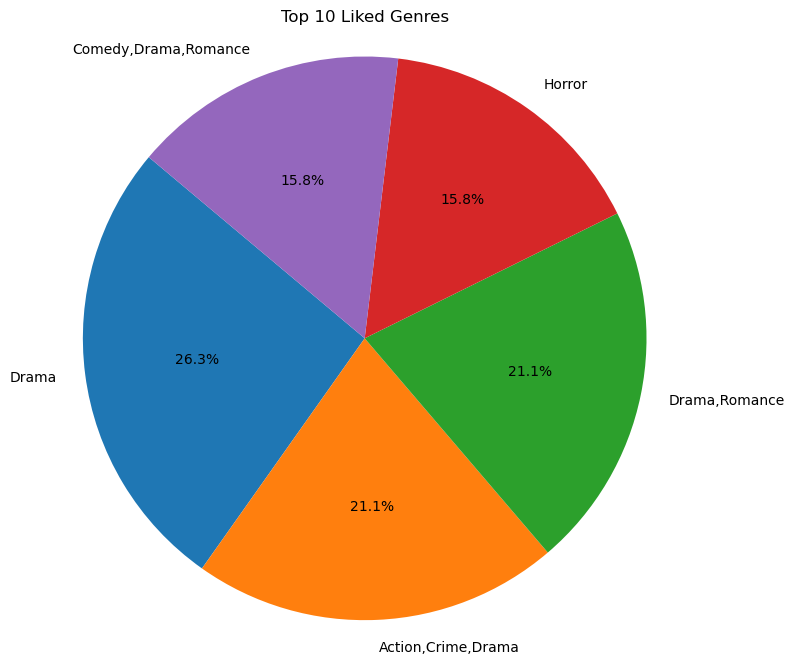

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

liked_genres_df = liked_genre.drop(columns="likeage")

# Count occurrences of each unique genre string
genre_counts = liked_genres_df['genres'].value_counts()
genre_counts_df = genre_counts.reset_index()
genre_counts_df.columns = ['Genre', 'Count']
sorted_genre_counts_df = genre_counts_df.sort_values(by='Count', ascending=False)
top_genres = sorted_genre_counts_df.head(5)
top_genres

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_genres['Count'], labels=top_genres['Genre'], autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Liked Genres')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
